In [1]:
%run init_notebook.py

In [7]:
from src.utils import load_pd_df, save_pd_df
from matplotlib.pyplot import cm

from src.nlp_utils import run_parallel
from src.utils import save_fig
from src.pymc_modelling import get_samp

In [45]:
tdet = load_pd_df("det_topics.feather")
tlda = load_pd_df("lda_topics.feather").reset_index()

In [4]:
res = run_parallel(tlda.drop(['id'], axis=1), id_col='date')

This process ran 449.5


In [33]:
dict_compare_az, dict_best_nknot, dict_compare_traces, dict_data_grouped = {}, {}, {}, {}

for r in res:
    comp_az, best_k, comp_trace, data_g = r
    dict_compare_az.update(comp_az)
    dict_best_nknot.update(best_k)
    dict_compare_traces.update(comp_trace)
    dict_data_grouped.update(data_g)

# plot

In [4]:
tdet_g = tdet.drop('id', axis=1).groupby('date').sum() #/ tdet.drop('id', axis=1).groupby('date').count().iloc[:,0].values[:,None]
tdet_g = tdet_g.rolling(15).mean().apply(lambda x: (x - x.min()) / (x.max() - x.min()))

tlda_g = tlda.drop('id', axis=1).groupby('date').sum() #/ tlda.groupby('date').count().iloc[:,0].values[:,None]
tlda_g = tlda_g.rolling(15).mean().apply(lambda x: (x - x.min()) / (x.max() - x.min()))

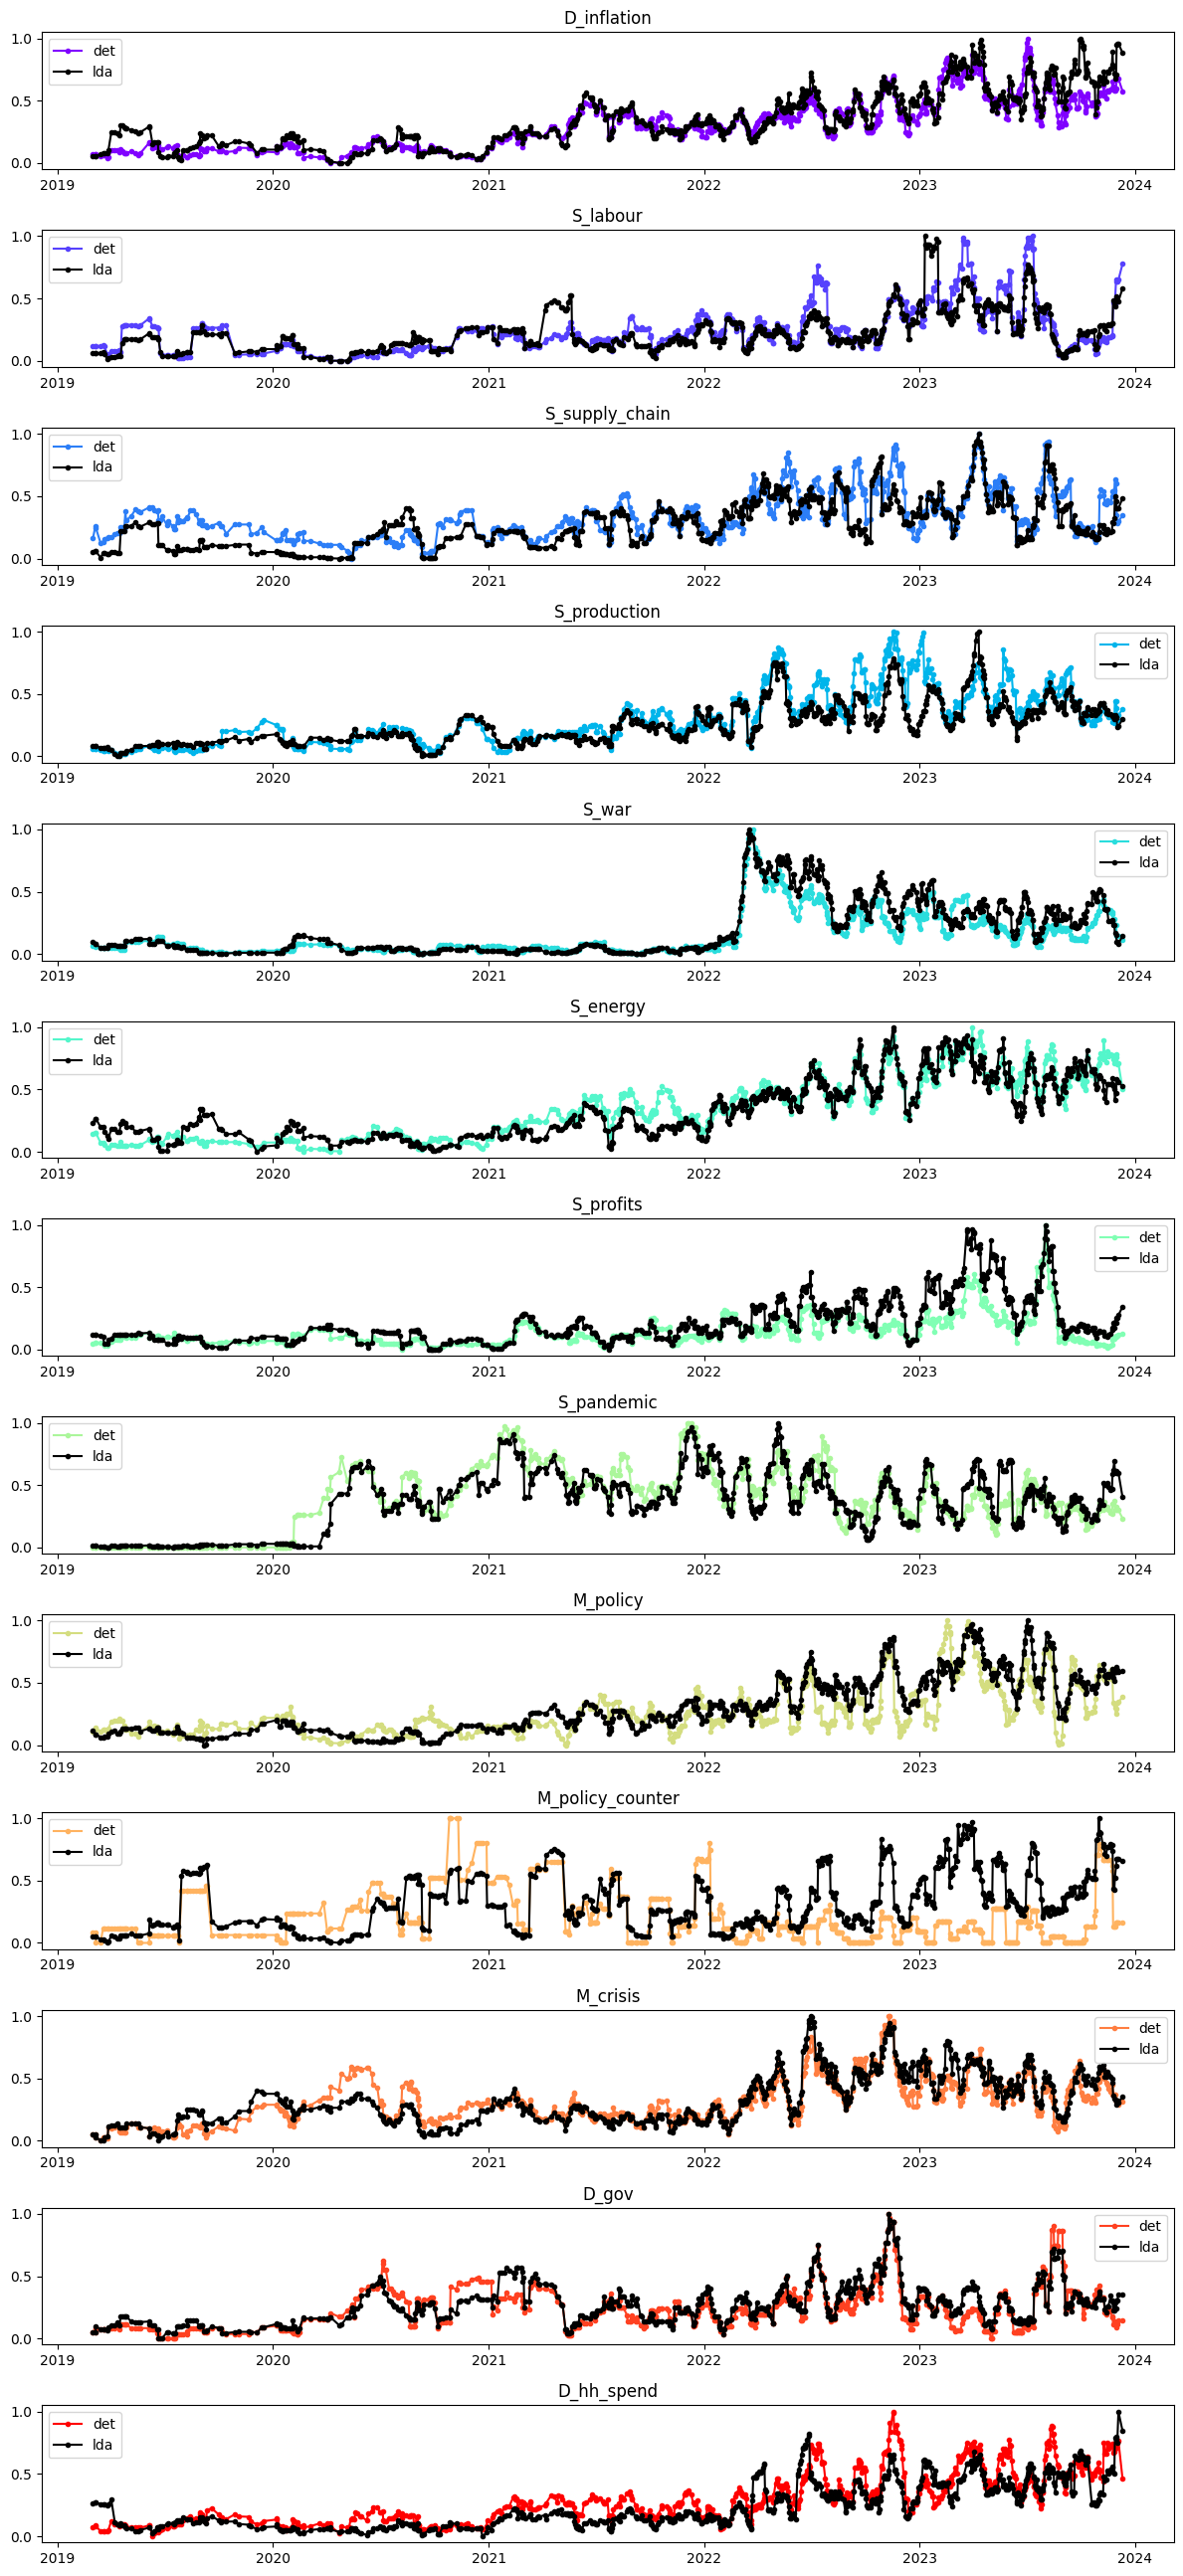

In [5]:
nrows = tdet_g.shape[1]
fig, axes = plt.subplots(nrows, 1, figsize=(12, 2 * nrows))
color = cm.rainbow(np.linspace(0, 1, nrows))

for i, ax in enumerate(axes.ravel()):
    col = tdet_g.columns[i]
    ax.plot(tdet_g.iloc[:, i], c=color[i], marker='.', )
    ax.plot(tlda_g.loc[:, col], c='black', marker='.',)
    ax.set_title(label=col)
    ax.legend(['det', 'lda'])
            
plt.tight_layout()
save_fig(fig, "02_topics_raw_det_lda.png")

# smooth

In [42]:
dict_best_nknot = {'D_inflation': 25,
 'S_labour': 20,
 'S_supply_chain': 20,
 'S_production': 20,
 'S_war': 40,
 'S_energy': 30,
 'S_profits': 20,
 'S_pandemic': 20,
 'M_policy': 20,
 'M_policy_counter': 20,
 'M_crisis': 20,
 'D_gov': 20,
 'D_hh_spend': 35}

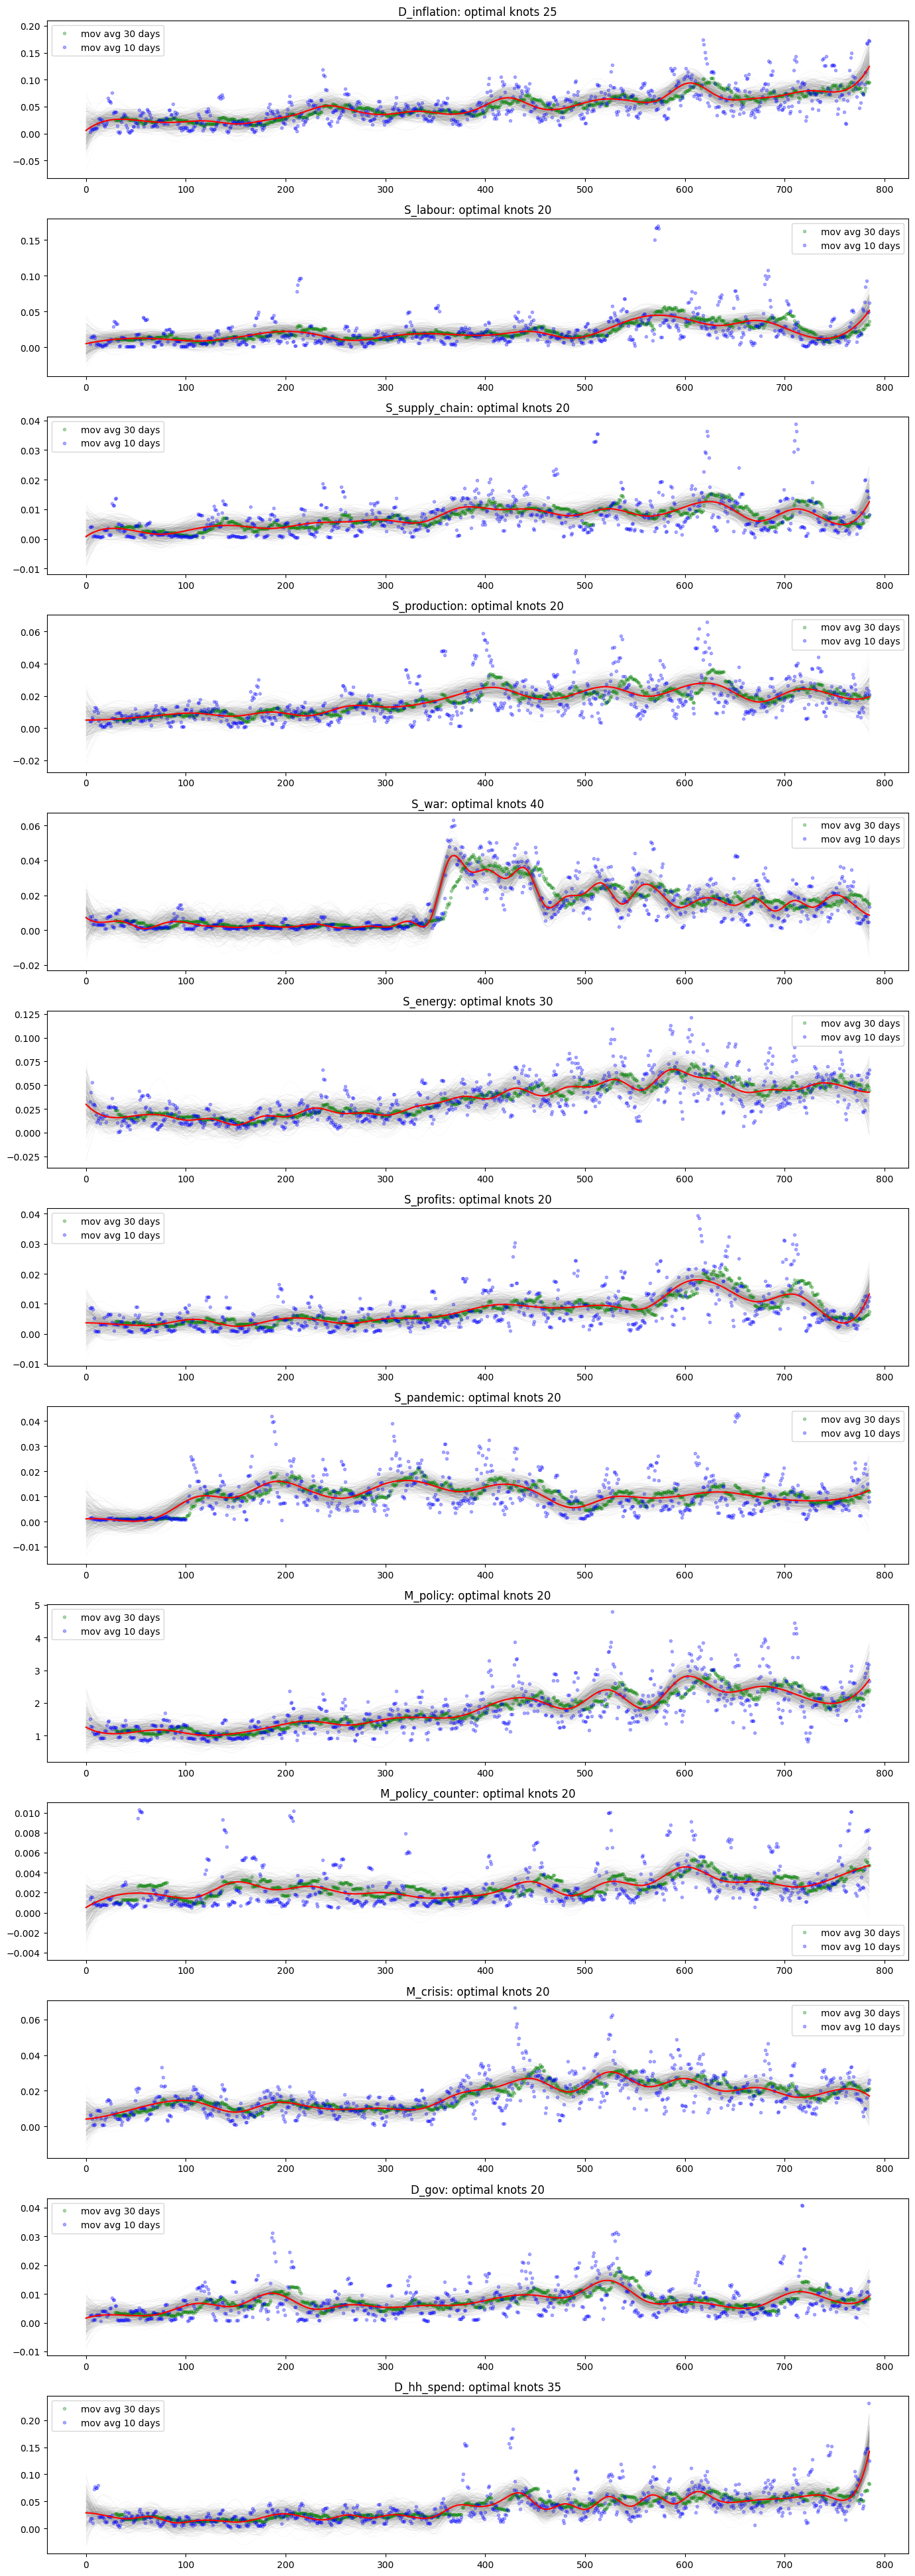

In [43]:
dict_smoothed = {}
dict_plot = {col: [dict_data_grouped[col], dict_compare_traces[col][v]] for col, v in dict_best_nknot.items()}

fig, axes = plt.subplots(len(dict_plot), 1, figsize=(14,3*len(dict_plot)))
for i, _ in enumerate(dict_plot.items()):
    col, _ = _
    data, trace = _
    
    axes.ravel()[i].set_title(f"{col}: optimal knots {dict_best_nknot[col]}") #f"knots_{trace.posterior['beta'].shape[-1]-2}", size=8)
    axes.ravel()[i].plot(
        trace.posterior['mu'][:, get_samp(1_000, 200)].values.reshape(2*200, data.shape[0]).T,
        lw=.1,
        alpha=.3,
        color='grey',
    )
    axes.ravel()[i].plot(data.rolling(30).mean().values, lw=0, marker='.', color='green', alpha=.3, label='mov avg 30 days')
    axes.ravel()[i].plot(data.rolling(5).mean().values, lw=0, marker='.', color='blue', alpha=.3, label='mov avg 10 days')
    axes.ravel()[i].plot(trace.posterior['mu'][:, get_samp(1_000)].values.reshape(2*100, data.shape[0]).T.mean(axis=1), color='red')
    axes.ravel()[i].legend()
    
    dict_smoothed[col] = trace.posterior['mu'][:, get_samp(1_000)].values.reshape(2*100, data.shape[0]).T.mean(axis=1)
plt.tight_layout();
save_fig(fig, "02_topics_smooth_det_lda.png")

In [46]:
tlda['date'] = tlda['date'].apply(lambda x: datetime(x.year, x.month, x.day))
tlda = tlda.set_index('date').join(pd.DataFrame(dict_smoothed, index=tlda.date.drop_duplicates()).add_suffix('_W'), how='left')

In [47]:
for col in [i for i in tlda.columns if i.split('_')[-1] == 'W']:
    tlda = tlda.join(tlda[col].drop_duplicates().diff().rename(f'{col}_diff'))

In [48]:
save_pd_df(tlda, 'lda_topics_smooth.feather')